In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
import sklearn
import seaborn as sns

np.random.seed = 42

df=pd.read_csv('../data/players_away_matches.csv')

#removing id and names and saving df without them
df = df.drop(df.columns[0], axis=1)
df.drop(columns=['playerName'], inplace=True)
df.drop(columns=['team_name'], inplace=True)

X_mod, X_val = train_test_split(df, test_size=0.3, random_state=42)

X_val.to_csv('../data/for_validators/soccer_players_validators.csv', index=False)
X_mod.to_csv('../data/for_modellers/soccer_players_modellers.csv', index=False)
df=pd.read_csv('../data/for_modellers/soccer_players_modellers.csv')

### In this milestone:
1. Data Preprocessing:
- removing some columns
- NULL/missing values (deleting or mean or another strategy)
- encoding of categorical columns (one hot encoding, ordinal encoding, ...)
- data transformation
- scaling/standarizing variables (in which models)
- outliers 
- function for preprocessing for validators
2. Pre-modelling

# 1. Data Preprocessing

## 1.1 Removing columns

## 1.2 Missing values

In [162]:
null_columns = df.columns[df.isnull().any()]

# Print the null columns
print("Null columns:")
print(null_columns)

Null columns:
Index(['aerials_lost', 'aerials_won', 'aerials_won_pct', 'assisted_shots',
       'ball_recoveries', 'blocked_passes', 'blocked_shots',
       'blocked_shots_saves', 'blocks', 'carries', 'carries_into_final_third',
       'carries_into_penalty_area', 'carry_distance',
       'carry_progressive_distance', 'clearances', 'corner_kicks',
       'corner_kicks_in', 'corner_kicks_out', 'corner_kicks_straight',
       'crosses_into_penalty_area', 'dispossessed', 'dribble_tackles',
       'dribble_tackles_pct', 'dribbled_past', 'dribbles',
       'dribbles_completed', 'dribbles_completed_pct', 'dribbles_vs', 'errors',
       'gca', 'minutes', 'miscontrols', 'npxg', 'nutmegs', 'pass_targets',
       'passes', 'passes_blocked', 'passes_completed', 'passes_completed_long',
       'passes_completed_medium', 'passes_completed_short', 'passes_dead',
       'passes_free_kicks', 'passes_ground', 'passes_head', 'passes_high',
       'passes_intercepted', 'passes_into_final_third',
       '

In [163]:
null_cols_count = df.isnull().any().sum()

print("Number of columns with null values:", null_cols_count)

Number of columns with null values: 99


In [164]:
# Count null values in each column
null_counts = df.isnull().sum()

print("Null counts for each column:")
print(null_counts[null_counts>0])

Null counts for each column:
aerials_lost            50
aerials_won             50
aerials_won_pct      15866
assisted_shots          50
ball_recoveries         50
                     ...  
touches_live_ball       50
touches_mid_3rd         50
xa                      50
xg                      50
championship_name      459
Length: 99, dtype: int64


The columns with nulls, which are numerical, represent various values from the match, such as number of passes, number of goals, tackles etc., so we will replace these NULLs by the mean of the values from the given column.

In [165]:
for column in df.select_dtypes(include=[np.number]).columns:
    if df[column].isnull().any():
        mean_value = df[column].mean()
        df[column].fillna(mean_value, inplace=True)

In [166]:
null_counts = df.isnull().sum()

print("Null counts for each column:")
print(null_counts[null_counts>0])

Null counts for each column:
championship_name    459
dtype: int64


We have nulls left in championship_name. As this is a categorical variable and we cannot guess what value should be there, let's replace it with ‘unknown’ - we are not going to delete it as most of the rows have values entered there (not nulls).

In [167]:
df['championship_name'].fillna('unknown', inplace=True)

null_counts = df.isnull().sum()
print("Null counts for each column:")
print(null_counts[null_counts>0])

Null counts for each column:
Series([], dtype: int64)


0 NULLs left - 1.2 done:)

## 1.3 Encoding of categorical values

Here we know from EDA that we have some categorical columns that have a lot of different unstructured values - we need to think about what to do with this

In [168]:
cat_cols = df.select_dtypes(include='object').columns

print(f'categorical columns: {cat_cols}')
print(f'number of categorical columns: {len(cat_cols)}')

categorical columns: Index(['awayTeamName', 'awayTeamTacticalSchema', 'homeTeamName',
       'homeTeamTacticalSchema', 'matchDate', 'championship_name'],
      dtype='object')
number of categorical columns: 6


In [169]:
unique_values_count = df[cat_cols].nunique()
print(unique_values_count)

awayTeamName              129
awayTeamTacticalSchema     32
homeTeamName              122
homeTeamTacticalSchema     32
matchDate                 565
championship_name           6
dtype: int64


In [170]:
unique_values = df['awayTeamTacticalSchema'].unique()
print(unique_values)

['(4-4-2)' '(4-2-3-1)' '(3-5-2)' '(4-5-1)' '(3-4-1-2)' '(4-1-4-1)'
 '(4-3-3)' '(3-4-3)' '(5-1-2-2)' '(4-4-2◆)' '(4-4-1-1)' '(4-2-2-2)'
 '(3-5-1-1)' '(3-2-2-2-1)' '(3-2-3-1-1)' '(4-1-3-2)' '(3-2-2-1-2)'
 '(5-3-2)' '(5-4-1)' '(3-2-3-2)' '(4-2-3-1◆)' '(4-3-2-1)' '(3-1-4-1-1)'
 '(4-2-2-1-1)' '(4-3-1-2)' '(3-1-4-2)' '(3-4-3◆)' '(3-3-2-2)' '(3-2-4-1)'
 '(3-3-2-1-1)' 'United' 'Marseille']


We have some incorrect values here, let's change/remove them.

In [171]:
df[df['awayTeamTacticalSchema']=='United']

,awayScore,awayTeamName,awayTeamTacticalSchema,homeScore,homeTeamName,homeTeamTacticalSchema,matchDate,matchWeek,aerials_lost,aerials_won,...,touches,touches_att_3rd,touches_att_pen_area,touches_def_3rd,touches_def_pen_area,touches_live_ball,touches_mid_3rd,xa,xg,championship_name
4286,1,Leeds United,United,1,Burnley,(4-4-2),2021-08-29,3,5.0,4.0,...,81.0,0.0,0.0,52.0,12.0,80.0,34.0,0.0,0.0,premier league
22856,1,Leeds United,United,1,Burnley,(4-4-2),2021-08-29,3,3.0,1.0,...,27.0,14.0,10.0,2.0,1.0,26.0,13.0,0.0,0.9,premier league
47938,1,Leeds United,United,1,Burnley,(4-4-2),2021-08-29,3,4.0,2.0,...,79.0,19.0,1.0,25.0,2.0,76.0,40.0,0.0,0.0,premier league
48081,1,Leeds United,United,1,Burnley,(4-4-2),2021-08-29,3,0.0,0.0,...,47.0,0.0,0.0,47.0,44.0,36.0,1.0,0.0,0.0,premier league
48988,1,Leeds United,United,1,Burnley,(4-4-2),2021-08-29,3,0.0,0.0,...,19.0,7.0,2.0,4.0,0.0,18.0,10.0,0.0,0.1,premier league
53264,1,Leeds United,United,1,Burnley,(4-4-2),2021-08-29,3,3.0,5.0,...,88.0,5.0,2.0,46.0,6.0,85.0,41.0,0.0,0.0,premier league


In [172]:
df[df['awayTeamTacticalSchema']=='Marseille']

,awayScore,awayTeamName,awayTeamTacticalSchema,homeScore,homeTeamName,homeTeamTacticalSchema,matchDate,matchWeek,aerials_lost,aerials_won,...,touches,touches_att_3rd,touches_att_pen_area,touches_def_3rd,touches_def_pen_area,touches_live_ball,touches_mid_3rd,xa,xg,championship_name
14150,0,Marseille,Marseille,2,Lille,(4-4-2),2021-10-03,9,0.0,2.0,...,21.0,10.0,5.0,2.0,1.0,21.0,10.0,0.0,0.3,ligue 1
15110,0,Marseille,Marseille,2,Lille,(4-4-2),2021-10-03,9,0.0,0.0,...,42.0,29.0,1.0,4.0,0.0,38.0,11.0,0.3,0.0,ligue 1
18643,0,Marseille,Marseille,2,Lille,(4-4-2),2021-10-03,9,2.0,0.0,...,67.0,18.0,1.0,24.0,7.0,59.0,31.0,0.0,0.0,ligue 1
19562,0,Marseille,Marseille,2,Lille,(4-4-2),2021-10-03,9,0.0,0.0,...,17.0,14.0,1.0,0.0,0.0,16.0,5.0,0.0,0.0,ligue 1
24063,0,Marseille,Marseille,2,Lille,(4-4-2),2021-10-03,9,0.0,0.0,...,41.0,0.0,0.0,26.0,7.0,39.0,15.0,0.0,0.0,ligue 1
25665,0,Marseille,Marseille,2,Lille,(4-4-2),2021-10-03,9,1.0,0.0,...,11.0,5.0,3.0,0.0,0.0,10.0,6.0,0.0,0.1,ligue 1
27168,0,Marseille,Marseille,2,Lille,(4-4-2),2021-10-03,9,1.0,2.0,...,37.0,13.0,1.0,11.0,0.0,33.0,17.0,0.0,0.0,ligue 1
33450,0,Marseille,Marseille,2,Lille,(4-4-2),2021-10-03,9,0.0,0.0,...,53.0,26.0,2.0,6.0,0.0,44.0,27.0,0.1,0.0,ligue 1
41038,0,Marseille,Marseille,2,Lille,(4-4-2),2021-10-03,9,0.0,1.0,...,73.0,9.0,0.0,31.0,9.0,72.0,38.0,0.0,0.0,ligue 1


In [173]:
#let's remove rows with teamNames as tactical schema
df = df[(df['awayTeamTacticalSchema'] != 'United') & (df['awayTeamTacticalSchema'] != 'Marseille')]


In [174]:
unique_values = df['awayTeamTacticalSchema'].unique()
print(unique_values)

['(4-4-2)' '(4-2-3-1)' '(3-5-2)' '(4-5-1)' '(3-4-1-2)' '(4-1-4-1)'
 '(4-3-3)' '(3-4-3)' '(5-1-2-2)' '(4-4-2◆)' '(4-4-1-1)' '(4-2-2-2)'
 '(3-5-1-1)' '(3-2-2-2-1)' '(3-2-3-1-1)' '(4-1-3-2)' '(3-2-2-1-2)'
 '(5-3-2)' '(5-4-1)' '(3-2-3-2)' '(4-2-3-1◆)' '(4-3-2-1)' '(3-1-4-1-1)'
 '(4-2-2-1-1)' '(4-3-1-2)' '(3-1-4-2)' '(3-4-3◆)' '(3-3-2-2)' '(3-2-4-1)'
 '(3-3-2-1-1)']


In [175]:
df.loc[df['awayTeamTacticalSchema'] == '(4-4-2◆)', 'awayTeamTacticalSchema'] = '(4-4-2)'
df.loc[df['awayTeamTacticalSchema'] == '(4-2-3-1◆)', 'awayTeamTacticalSchema'] = '(4-2-3-1)'
df.loc[df['awayTeamTacticalSchema'] == '(3-4-3◆)', 'awayTeamTacticalSchema'] = '(3-4-3)'


In [176]:
unique_values = df['awayTeamTacticalSchema'].unique()
print(unique_values)

['(4-4-2)' '(4-2-3-1)' '(3-5-2)' '(4-5-1)' '(3-4-1-2)' '(4-1-4-1)'
 '(4-3-3)' '(3-4-3)' '(5-1-2-2)' '(4-4-1-1)' '(4-2-2-2)' '(3-5-1-1)'
 '(3-2-2-2-1)' '(3-2-3-1-1)' '(4-1-3-2)' '(3-2-2-1-2)' '(5-3-2)' '(5-4-1)'
 '(3-2-3-2)' '(4-3-2-1)' '(3-1-4-1-1)' '(4-2-2-1-1)' '(4-3-1-2)'
 '(3-1-4-2)' '(3-3-2-2)' '(3-2-4-1)' '(3-3-2-1-1)']


Now the same for homeTeamTacticalSchema.

In [177]:
unique_values = df['homeTeamTacticalSchema'].unique()
print(unique_values)

['(4-3-3)' '(4-2-3-1)' '(4-4-2)' '(3-5-2)' '(4-1-4-1)' '(4-4-2◆)'
 '(3-4-3)' '(5-1-2-2)' '(3-5-1-1)' '(4-4-1-1)' '(3-4-1-2)' '(4-5-1)'
 '(3-1-4-2)' '(4-2-2-2)' '(5-3-2)' '(4-3-2-1)' '(3-2-4-1)' '(3-2-2-1-2)'
 '(3-3-2-2)' '(3-2-1-2-2)' '(3-4-3◆)' '(3-2-3-1-1)' '(3-2-2-2-1)'
 '(4-1-3-2)' '(3-2-3-2)' '(4-3-1-2)' '(5-4-1)' '(3-1-4-1-1)' '(4-2-2-1-1)'
 '(4-2-3-1◆)' '(3-5-2◆)' '(4-3-3◆)']


In [178]:
df.loc[df['homeTeamTacticalSchema'] == '(4-4-2◆)', 'homeTeamTacticalSchema'] = '(4-4-2)'
df.loc[df['homeTeamTacticalSchema'] == '(4-2-3-1◆)', 'homeTeamTacticalSchema'] = '(4-2-3-1)'
df.loc[df['homeTeamTacticalSchema'] == '(3-4-3◆)', 'homeTeamTacticalSchema'] = '(3-4-3)'
df.loc[df['homeTeamTacticalSchema'] == '(3-5-2◆)', 'homeTeamTacticalSchema'] = '(3-5-2)'
df.loc[df['homeTeamTacticalSchema'] == '(4-3-3◆)', 'homeTeamTacticalSchema'] = '(4-3-3)'

In [179]:
unique_values = df['homeTeamTacticalSchema'].unique()
print(unique_values)

['(4-3-3)' '(4-2-3-1)' '(4-4-2)' '(3-5-2)' '(4-1-4-1)' '(3-4-3)'
 '(5-1-2-2)' '(3-5-1-1)' '(4-4-1-1)' '(3-4-1-2)' '(4-5-1)' '(3-1-4-2)'
 '(4-2-2-2)' '(5-3-2)' '(4-3-2-1)' '(3-2-4-1)' '(3-2-2-1-2)' '(3-3-2-2)'
 '(3-2-1-2-2)' '(3-2-3-1-1)' '(3-2-2-2-1)' '(4-1-3-2)' '(3-2-3-2)'
 '(4-3-1-2)' '(5-4-1)' '(3-1-4-1-1)' '(4-2-2-1-1)']


We will transform these values into 3 columns: defense_schema (nr of players in defense), middle_schema, strikers_schema.

In [180]:
print(df['homeTeamTacticalSchema'].nunique())

27


In [181]:
def extract_numbers(formation):
    nums = formation.strip('()').split('-')
    nums = [int(num) for num in nums]
    while len(nums) < 3:
        nums.append(0)
    return nums

formations_home = [extract_numbers(formation) for formation in df['homeTeamTacticalSchema']]
formations_home

[[4, 3, 3],
 [4, 2, 3, 1],
 [4, 3, 3],
 [4, 4, 2],
 [3, 5, 2],
 [3, 5, 2],
 [4, 3, 3],
 [4, 1, 4, 1],
 [4, 4, 2],
 [3, 5, 2],
 [4, 4, 2],
 [4, 2, 3, 1],
 [4, 3, 3],
 [3, 4, 3],
 [4, 3, 3],
 [4, 3, 3],
 [4, 4, 2],
 [4, 4, 2],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 1, 4, 1],
 [4, 2, 3, 1],
 [3, 5, 2],
 [4, 2, 3, 1],
 [4, 4, 2],
 [4, 3, 3],
 [3, 5, 2],
 [4, 2, 3, 1],
 [4, 4, 2],
 [4, 2, 3, 1],
 [3, 4, 3],
 [4, 2, 3, 1],
 [3, 4, 3],
 [4, 4, 2],
 [4, 2, 3, 1],
 [4, 3, 3],
 [3, 4, 3],
 [4, 4, 2],
 [4, 4, 2],
 [4, 1, 4, 1],
 [4, 3, 3],
 [4, 3, 3],
 [4, 1, 4, 1],
 [4, 2, 3, 1],
 [5, 1, 2, 2],
 [4, 3, 3],
 [4, 3, 3],
 [4, 3, 3],
 [3, 5, 1, 1],
 [3, 4, 3],
 [3, 5, 2],
 [3, 5, 2],
 [4, 4, 2],
 [3, 4, 3],
 [3, 4, 3],
 [4, 2, 3, 1],
 [4, 1, 4, 1],
 [3, 4, 3],
 [4, 3, 3],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 4, 2],
 [4, 4, 1, 1],
 [4, 2, 3, 1],
 [4, 3, 3],
 [4, 2, 3, 1],
 [3, 4, 3],
 [4, 1, 4, 1],
 [3, 4, 3],
 [3, 5, 2],
 [4, 3, 3],
 [4, 2, 3, 1],
 [4, 1, 4, 1],
 [4, 4, 2],
 [3, 4, 3],
 [4, 2, 3, 1],
 [4,

In [182]:
#count nr of middle players
def sum_middle_values(formation):
    return sum(formation[1:-1])

df['defense_schema_home'] = [form[0] for form in formations_home]
df['middle_schema_home'] = [sum_middle_values(form) for form in formations_home]
df['strikers_schema_home'] = [form[-1] for form in formations_home]


In [183]:
df.drop(columns=['homeTeamTacticalSchema'], inplace=True)
df.head()

,awayScore,awayTeamName,awayTeamTacticalSchema,homeScore,homeTeamName,matchDate,matchWeek,aerials_lost,aerials_won,aerials_won_pct,...,touches_def_3rd,touches_def_pen_area,touches_live_ball,touches_mid_3rd,xa,xg,championship_name,defense_schema_home,middle_schema_home,strikers_schema_home
0,4,Napoli,(4-4-2),1,Spezia,2021-05-08,35,0.0,0.0,47.409751,...,45.0,42.0,42.0,0.0,0.0,0.0,seria a,4,3,3
1,4,Bayern Munich,(4-2-3-1),0,Schalke 04,2021-01-24,18,0.0,1.0,100.000000,...,15.0,4.0,50.0,23.0,0.0,0.0,bundesliga,4,5,1
2,0,Osasuna,(3-5-2),0,Levante,2021-12-05,16,0.0,1.0,100.000000,...,10.0,3.0,46.0,27.0,0.0,0.0,liga,4,3,3
3,2,Crystal Palace,(4-5-1),2,Arsenal,2019-10-27,10,0.0,1.0,100.000000,...,18.0,6.0,57.0,43.0,0.0,0.8,premier league,4,4,2
4,0,Hertha BSC,(4-2-3-1),2,Union Berlin,2021-11-20,12,3.0,0.0,0.000000,...,4.0,1.0,33.0,15.0,0.0,0.0,bundesliga,3,5,2


In [184]:
print(df['awayTeamTacticalSchema'].nunique())

27


In [185]:
formations_away = [extract_numbers(formation) for formation in df['awayTeamTacticalSchema']]
formations_away

[[4, 4, 2],
 [4, 2, 3, 1],
 [3, 5, 2],
 [4, 5, 1],
 [4, 2, 3, 1],
 [3, 4, 1, 2],
 [4, 2, 3, 1],
 [4, 4, 2],
 [3, 5, 2],
 [4, 4, 2],
 [4, 2, 3, 1],
 [4, 1, 4, 1],
 [4, 2, 3, 1],
 [4, 3, 3],
 [4, 2, 3, 1],
 [4, 4, 2],
 [3, 5, 2],
 [4, 4, 2],
 [4, 4, 2],
 [4, 3, 3],
 [4, 2, 3, 1],
 [4, 4, 2],
 [3, 4, 3],
 [3, 4, 1, 2],
 [4, 2, 3, 1],
 [4, 1, 4, 1],
 [3, 5, 2],
 [4, 4, 2],
 [4, 4, 2],
 [4, 4, 2],
 [4, 3, 3],
 [3, 4, 1, 2],
 [3, 4, 3],
 [4, 4, 2],
 [4, 2, 3, 1],
 [4, 3, 3],
 [3, 4, 3],
 [4, 2, 3, 1],
 [3, 4, 1, 2],
 [3, 5, 2],
 [4, 2, 3, 1],
 [4, 4, 2],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [5, 1, 2, 2],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 4, 2],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [3, 4, 1, 2],
 [3, 5, 2],
 [3, 4, 3],
 [4, 2, 3, 1],
 [3, 5, 2],
 [3, 5, 2],
 [4, 1, 4, 1],
 [3, 4, 3],
 [4, 3, 3],
 [4, 3, 3],
 [4, 1, 4, 1],
 [4, 4, 2],
 [4, 4, 2],
 [4, 3, 3],
 [3, 5, 2],
 [4, 4, 2],
 [3, 5, 2],
 [4, 4, 2],
 [3, 4, 3],
 [4, 3, 3],
 [4, 4, 1, 1],
 [4, 2, 3, 1],
 [4, 4, 2],
 [4, 3, 3],
 [3, 4, 3],
 [3, 5, 2]

In [186]:
df['defense_schema_away'] = [form[0] for form in formations_away]
df['middle_schema_away'] = [sum_middle_values(form) for form in formations_away]
df['strikers_schema_away'] = [form[-1] for form in formations_away]

In [187]:
df.drop(columns=['awayTeamTacticalSchema'], inplace=True)
df.head()

,awayScore,awayTeamName,homeScore,homeTeamName,matchDate,matchWeek,aerials_lost,aerials_won,aerials_won_pct,age,...,touches_mid_3rd,xa,xg,championship_name,defense_schema_home,middle_schema_home,strikers_schema_home,defense_schema_away,middle_schema_away,strikers_schema_away
0,4,Napoli,1,Spezia,2021-05-08,35,0.0,0.0,47.409751,24.0,...,0.0,0.0,0.0,seria a,4,3,3,4,4,2
1,4,Bayern Munich,0,Schalke 04,2021-01-24,18,0.0,1.0,100.000000,20.0,...,23.0,0.0,0.0,bundesliga,4,5,1,4,5,1
2,0,Osasuna,0,Levante,2021-12-05,16,0.0,1.0,100.000000,23.0,...,27.0,0.0,0.0,liga,4,3,3,3,5,2
3,2,Crystal Palace,2,Arsenal,2019-10-27,10,0.0,1.0,100.000000,28.0,...,43.0,0.0,0.8,premier league,4,4,2,4,5,1
4,0,Hertha BSC,2,Union Berlin,2021-11-20,12,3.0,0.0,0.000000,24.0,...,15.0,0.0,0.0,bundesliga,3,5,2,4,5,1


Now let's transform matchDate as in EDA: into year and month.

In [188]:
df['matchYear'] = pd.to_datetime(df['matchDate']).dt.year
df['matchMonth'] = pd.to_datetime(df['matchDate']).dt.month

df.drop(columns=['matchDate'], inplace=True)
df.head()

,awayScore,awayTeamName,homeScore,homeTeamName,matchWeek,aerials_lost,aerials_won,aerials_won_pct,age,assisted_shots,...,xg,championship_name,defense_schema_home,middle_schema_home,strikers_schema_home,defense_schema_away,middle_schema_away,strikers_schema_away,matchYear,matchMonth
0,4,Napoli,1,Spezia,35,0.0,0.0,47.409751,24.0,0.0,...,0.0,seria a,4,3,3,4,4,2,2021,5
1,4,Bayern Munich,0,Schalke 04,18,0.0,1.0,100.000000,20.0,0.0,...,0.0,bundesliga,4,5,1,4,5,1,2021,1
2,0,Osasuna,0,Levante,16,0.0,1.0,100.000000,23.0,1.0,...,0.0,liga,4,3,3,3,5,2,2021,12
3,2,Crystal Palace,2,Arsenal,10,0.0,1.0,100.000000,28.0,0.0,...,0.8,premier league,4,4,2,4,5,1,2019,10
4,0,Hertha BSC,2,Union Berlin,12,3.0,0.0,0.000000,24.0,0.0,...,0.0,bundesliga,3,5,2,4,5,1,2021,11


In [189]:
cat_cols = df.select_dtypes(include='object').columns
unique_values_count = df[cat_cols].nunique()
print(unique_values_count)

awayTeamName         129
homeTeamName         122
championship_name      6
dtype: int64


We will remove team names, as they are not sequential, so we cannot use label encoding and there are too many values to use hasher without collisions. besides, the name of a team should not influence our assessment of how someone performed in a match.

In [190]:
df.drop(columns=['awayTeamName'], inplace=True)
df.drop(columns=['homeTeamName'], inplace=True)

For championship name we can use one hot encoding, as there are not so many different values.

In [191]:
df.reset_index(drop=True, inplace=True)

In [192]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

transformed_data = ohe.fit_transform(df[['championship_name']])

df_encoded = pd.DataFrame(transformed_data.toarray(), columns=ohe.get_feature_names_out(['championship_name']))
df.drop(columns=['championship_name'], inplace=True)
df = df.join(df_encoded)

In [193]:
df.head()

,awayScore,homeScore,matchWeek,aerials_lost,aerials_won,aerials_won_pct,age,assisted_shots,assists,ball_recoveries,...,middle_schema_away,strikers_schema_away,matchYear,matchMonth,championship_name_bundesliga,championship_name_liga,championship_name_ligue 1,championship_name_premier league,championship_name_seria a,championship_name_unknown
0,4,1,35,0.0,0.0,47.409751,24.0,0.0,0,1.0,...,4,2,2021,5,0.0,0.0,0.0,0.0,1.0,0.0
1,4,0,18,0.0,1.0,100.000000,20.0,0.0,0,11.0,...,5,1,2021,1,1.0,0.0,0.0,0.0,0.0,0.0
2,0,0,16,0.0,1.0,100.000000,23.0,1.0,0,10.0,...,5,2,2021,12,0.0,1.0,0.0,0.0,0.0,0.0
3,2,2,10,0.0,1.0,100.000000,28.0,0.0,0,16.0,...,5,1,2019,10,0.0,0.0,0.0,1.0,0.0,0.0
4,0,2,12,3.0,0.0,0.000000,24.0,0.0,0,6.0,...,5,1,2021,11,1.0,0.0,0.0,0.0,0.0,0.0


Let's check if we didn't create any NULL values by mistake.

In [194]:
null_counts = df.isnull().sum()
print("Null counts for each column:")
print(null_counts[null_counts>0])

Null counts for each column:
Series([], dtype: int64)


In [195]:
cat_cols = df.select_dtypes(include='object').columns

print(f'categorical columns: {cat_cols}')
print(f'number of categorical columns: {len(cat_cols)}')

categorical columns: Index([], dtype='object')
number of categorical columns: 0


No categorical values - 1.3 done:)

## 1.4 Outliers

Automatic outlier detection using knn from pyod

In [196]:
from pyod.models.knn import KNN
clf = KNN(contamination=0.04)
clf.fit(df)
df['outliers'] = clf.labels_
df['outliers'].value_counts()

0    51181
1     2133
Name: outliers, dtype: int64

In [197]:
df = df[df['outliers']==0]
df.drop(columns=['outliers'], inplace=True)

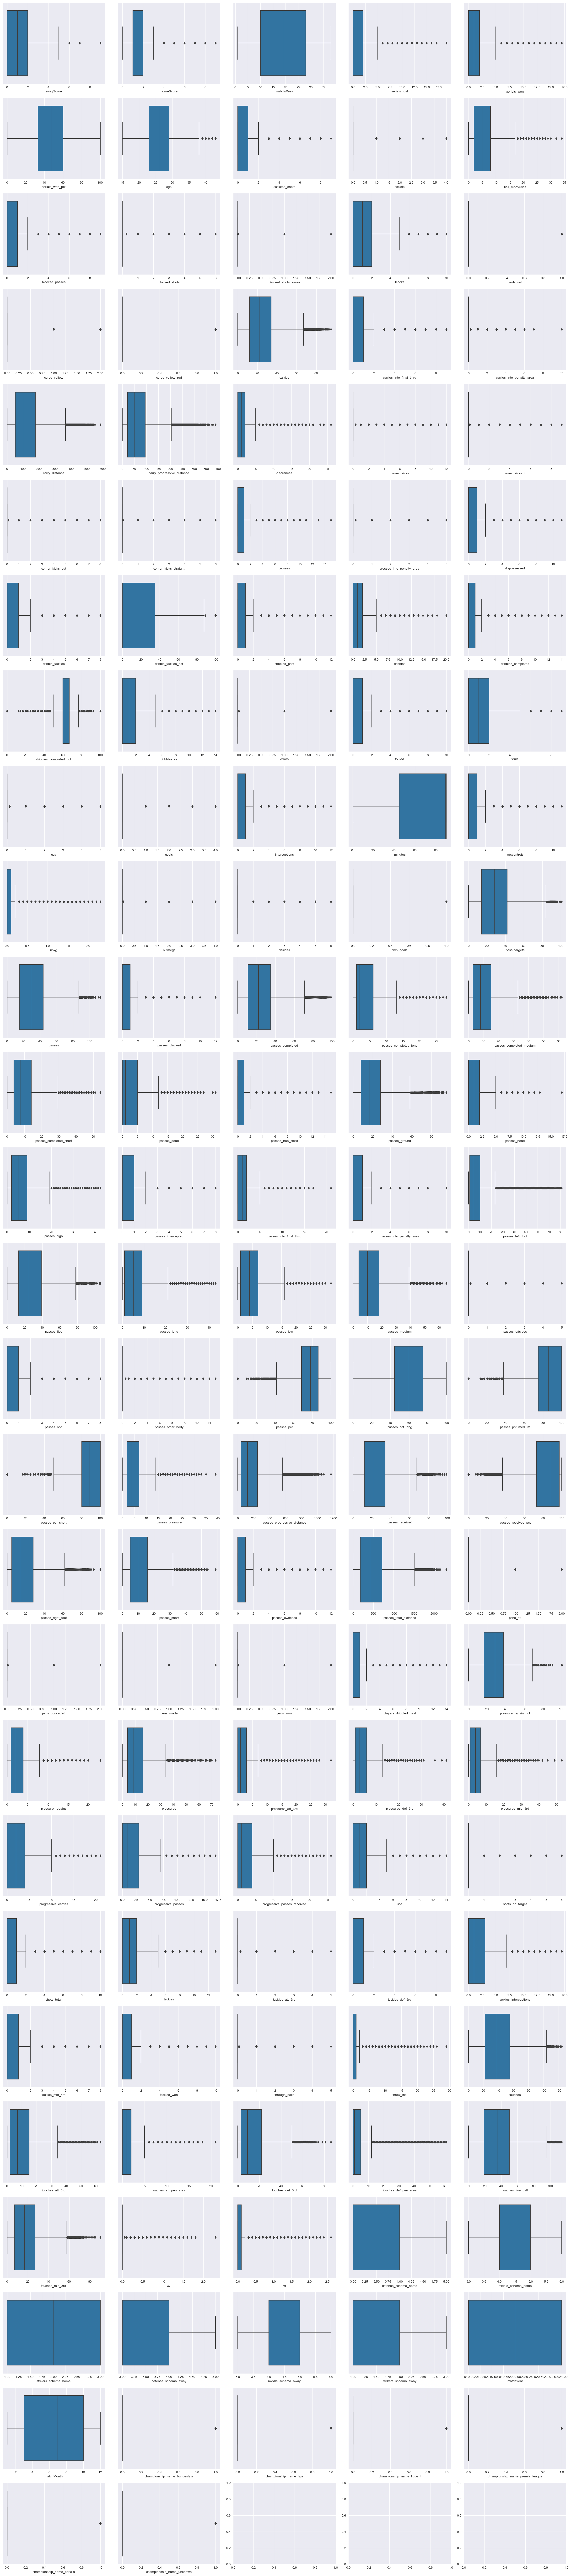

In [146]:
fig, axs = plt.subplots(27, 5, figsize = (24, 108))
axs = axs.flatten()

for i, col in enumerate(df.columns):
    sns.boxplot(data=df, x=col, ax=axs[i])

plt.tight_layout()
plt.show()

It didn't remove rare but important values such as a lot of goals. It did what we wanted. 1.4 done

In [ ]:
df.to_csv('../data/for_modellers/after_feature_engineering.csv', index=False)

In [198]:
df=pd.read_csv('../data/for_modellers/after_feature_engineering.csv')

## 1.5 Data transformation and scaling

We will use PowerTransformer

In [199]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
pt = PowerTransformer(method='yeo-johnson')

df_transformed = pt.fit_transform(df)
df_transformed = scaler.fit_transform(df_transformed)

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:3408: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda


BracketError: The algorithm terminated without finding a valid bracket. Consider trying different initial points.

NIE DZIALA - do poprawy

# 2. Pre-modelling